# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from tqdm.auto import tqdm
tqdm.pandas()

import pickle

D:\Users\Ritvik\Anaconda3\envs\datascience\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Data

In [2]:
data = pd.read_csv('E:/Scrapped-Data/InshortsScraped.csv')

In [3]:
data.shape

(38720, 8)

In [4]:
data.head()

,news,national,sports,world,politics,technology,entertainment,hatke
0,7 IITs among India's top higher education inst...,1,0,0,0,0,0,0
1,They forget she's 14: Devgn on trolls criticis...,0,0,0,0,0,1,0
2,Haven't earned so much that I can wear new clo...,0,0,0,0,0,1,0
3,Fans in US sing Desi Girl for Priyanka outside...,0,0,0,0,0,1,0
4,"Dhoni bhai was very angry, he hugged me after ...",0,1,0,0,0,0,0


In [5]:
data.describe()

,national,sports,world,politics,technology,entertainment,hatke
count,38720.000000,38720.000000,38720.000000,38720.000000,38720.000000,38720.000000,38720.000000
mean,0.234349,0.165134,0.152531,0.129520,0.224819,0.152299,0.007593
std,0.423597,0.371307,0.359539,0.335779,0.417469,0.359315,0.086807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Data Preprocesing

## Data Cleaning

In [6]:
import nltk, re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

def spell_correct(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\0s", "0", text)    
    return text

def remove_url(text):
    URL_REGEX = re.compile(r'''((http[s]?://)[^ <>'"{}|\\^`[\]]*)''')
    return URL_REGEX.sub(r' ', text)

remove_punc = lambda x : re.sub(r"\W", ' ', x)

remove_num = lambda x : re.sub(r"\d", ' ', x)

remove_extra_spaces = lambda x : re.sub(r"\s+", ' ', x)

lower_case = lambda x : x.lower()

with open('stopwords.txt') as f:
    sw = map(lambda x : x.strip(), f.readlines())
stop_words = set(nltk.corpus.stopwords.words('english'))|set(sw)
remove_stopwords = lambda x: ' '.join(word for word in x.split() if word not in stop_words)

ps = PorterStemmer()
ps_stem = lambda x: ' '.join(ps.stem(word) for word in x.split())

wnl = WordNetLemmatizer()
wnl_lemmatize = lambda x: ' '.join(wnl.lemmatize(word) for word in x.split())

def tag_pos(x):
    tag_list =  nltk.pos_tag(nltk.word_tokenize(x))
    pos = ""
    for t in tag_list:
        pos += t[0] +'(' + t[1] +')' + ' '
    return pos

def cleanText(x, rsw, stm, lem, tgps):
    x = str(x)
    x = remove_url(x)
    x = lower_case(x)
    x = spell_correct(x)
    x = remove_punc(x)
    x = remove_num(x)
    x = remove_extra_spaces(x)
    
    if rsw:
        x = remove_stopwords(x)
    if stm:
        x = ps_stem(x)
    if lem:
        x = wnl_lemmatize(x)
    if tgps:
        x = tag_pos(x)
    return x

In [7]:
data['news_c'] = data['news'].progress_apply(lambda x : cleanText(x, True, False, False, False))

In [8]:
labels = ['national', 'sports', 'world', 'politics', 'technology', 'entertainment', 'hatke']

## Visualization

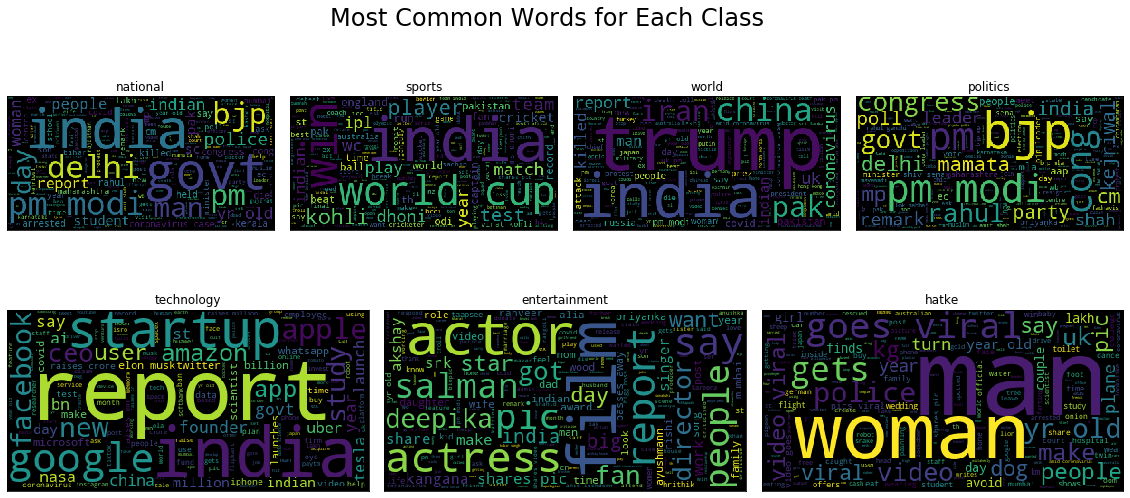

In [9]:
axes = []
fig = plt.figure(figsize=(20, 8))
fig.suptitle('Most Common Words for Each Class', fontsize=24)
for i in range(4):
    axes.append(plt.subplot2grid((2, 12), (0, i*3), colspan=3))
for i in range(3):
    axes.append(plt.subplot2grid((2, 12), (1, i*4), colspan=4))
    
for i, col in enumerate(labels):
    axes[i].imshow(WordCloud().generate_from_text(' '.join(data[data[col] == 1]['news_c'].values)))
    axes[i].set_title(col)
    axes[i].xaxis.set_visible(False)
    axes[i].yaxis.set_visible(False)

## Vectorizing

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
vectorizer = TfidfVectorizer()
vectorizer.fit(data['news_c'])
X = vectorizer.transform(data['news_c'])

In [12]:
Y = data.drop(['news', 'news_c'], axis = 1).values

In [13]:
print("X shape:", X.shape, "Y shape: ", Y.shape)

X shape: (38720, 24695) Y shape:  (38720, 7)


# Machine Learning

In [14]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [15]:
from utils import train_model_one_vs_rest

## Baseline

Mean Hamming Loss 0.2511 +- 0.0012


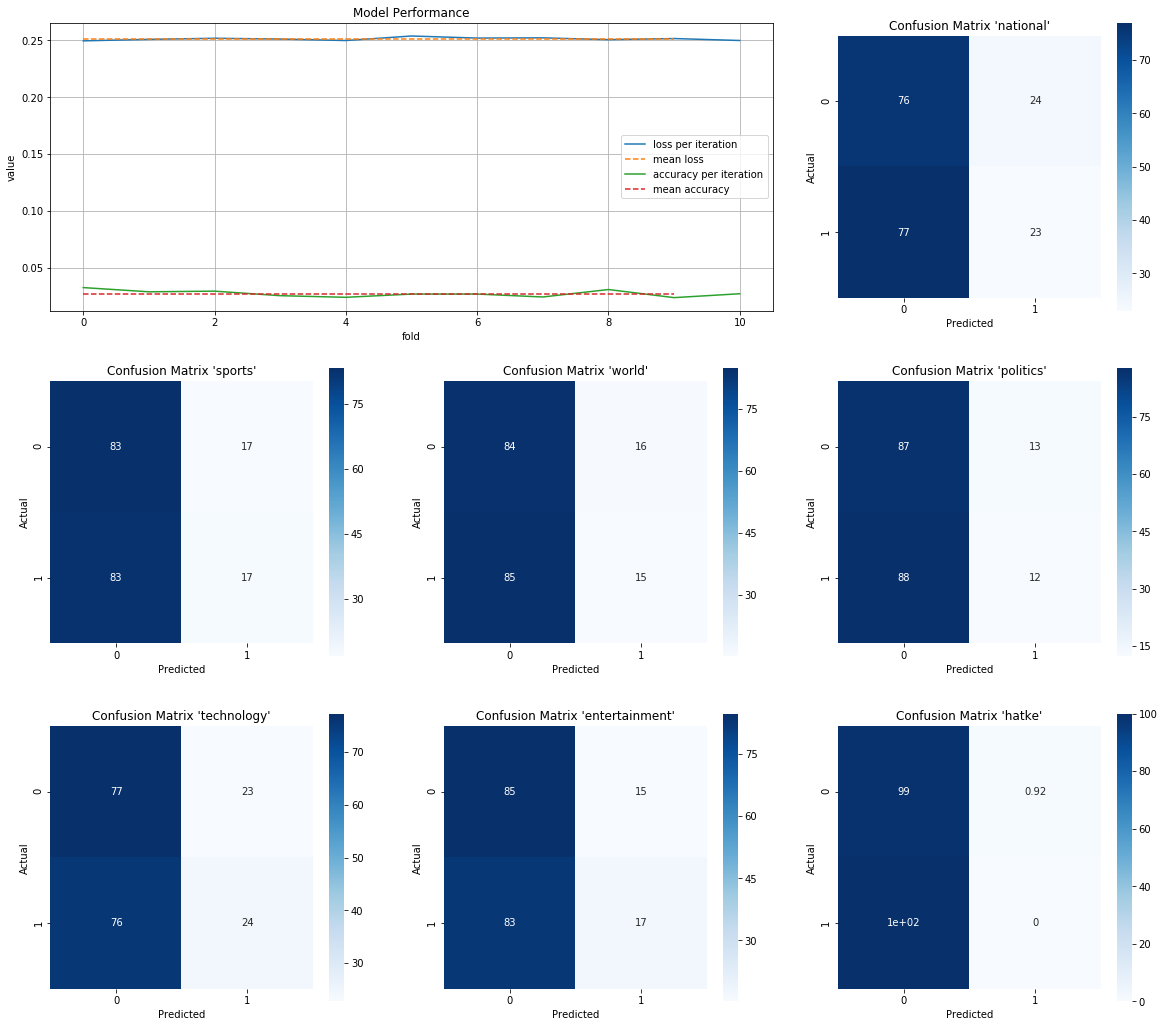

In [16]:
model = DummyClassifier(strategy='stratified', random_state=101)
performance, cm, model = train_model_one_vs_rest(model, X, Y, labels)
print('Mean Hamming Loss', round(np.mean(performance['loss']), 4), '+-', round(np.std(performance['loss']), 4))

## NB

Mean Hamming Loss 0.0747 +- 0.0014


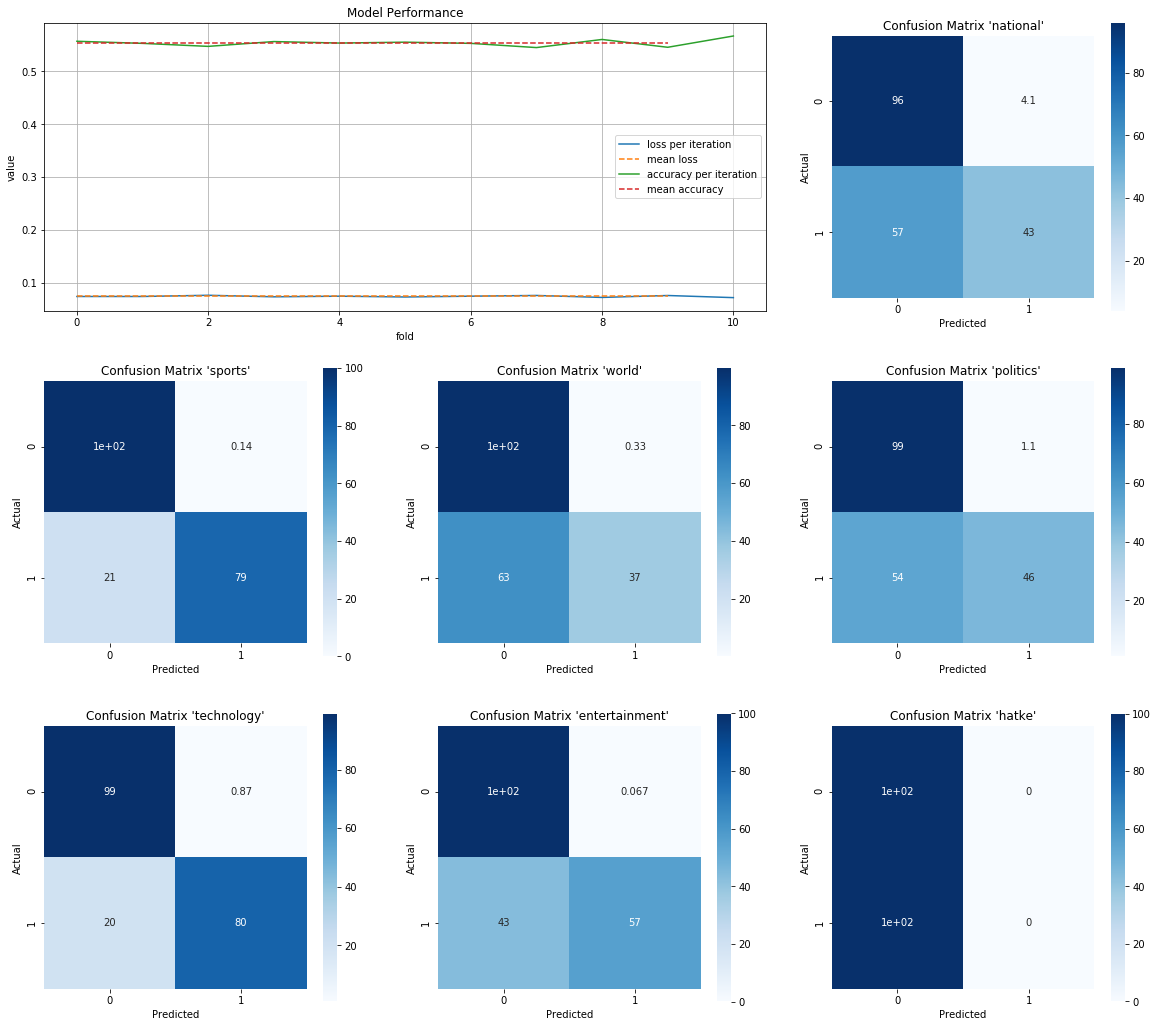

In [17]:
model = MultinomialNB()
mnb_performance, mnb_cm, mnb_model = train_model_one_vs_rest(model, X, Y, labels)
print('Mean Hamming Loss', round(np.mean(mnb_performance['loss']), 4), '+-', round(np.std(mnb_performance['loss']), 4))

## LR

Mean Hamming Loss 0.0593 +- 0.002


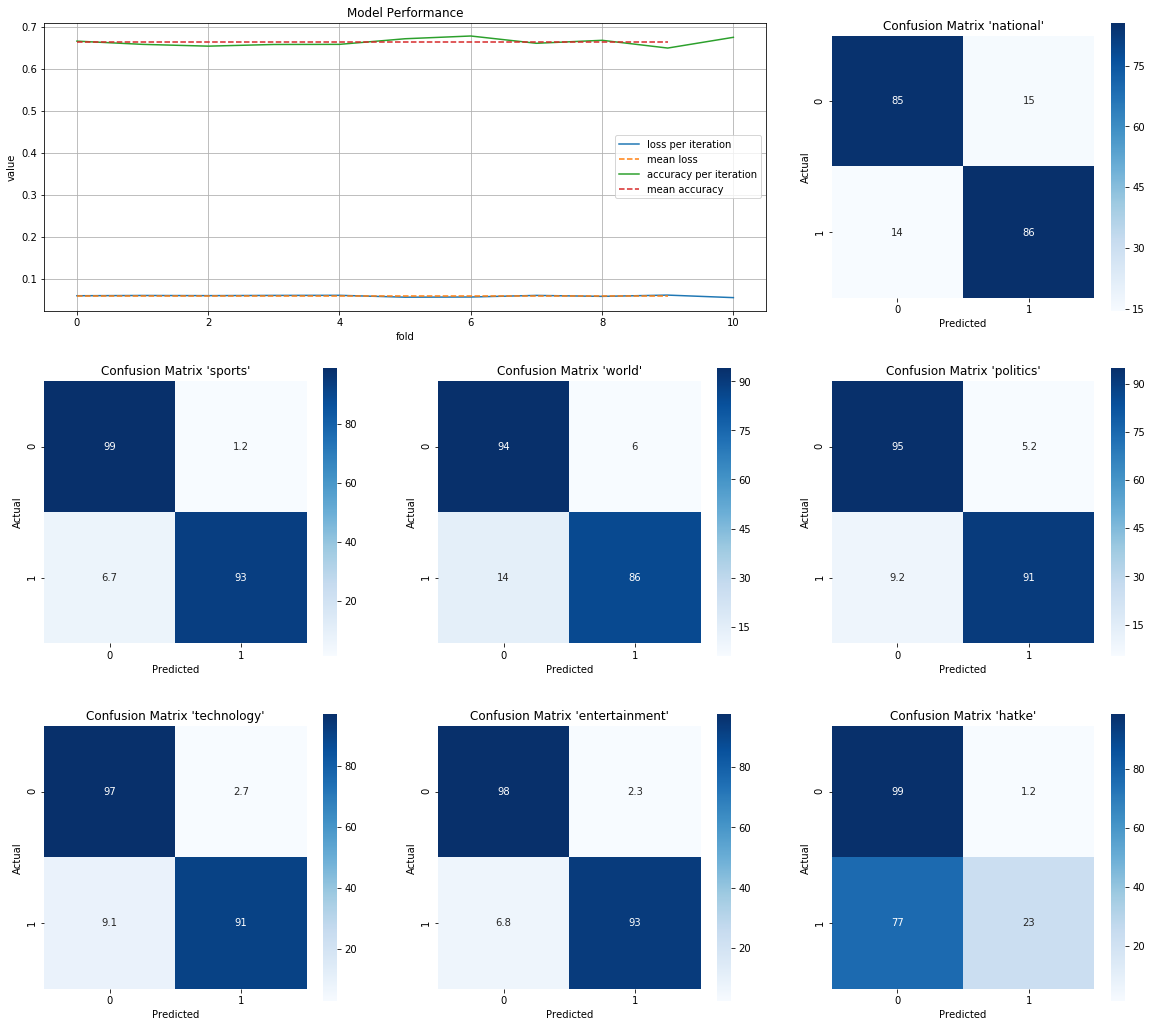

In [18]:
model = LogisticRegression(class_weight='balanced', random_state=101, solver='lbfgs', max_iter=1_000, warm_start=True)
lr2_performance, lr2_cm, lr2_model = train_model_one_vs_rest(model, X, Y, labels)
print('Mean Hamming Loss', round(np.mean(lr2_performance['loss']), 4), '+-', round(np.std(lr2_performance['loss']), 4))

## NB-LR

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

In [20]:
from scipy import sparse

In [21]:
class TextCleaner(BaseEstimator):
    
    def __init__(self, rsw=True, stm=False, lem=False):
        
        self.rsw = rsw
        self.stm = stm
        self.lem = lem
        
        self.stop_words = set(nltk.corpus.stopwords.words('english'))
        self.ps = PorterStemmer()
        self.wnl = WordNetLemmatizer()
        
    def fit(self, x, y=None):
        return self
    
    def spell_correct(self, text):
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"what's", "what is ", text) 
        text = re.sub(r"'s", " ", text)
        text = re.sub(r"'ve", " have ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"'re", " are ", text)
        text = re.sub(r"'d", " would ", text)
        text = re.sub(r"'ll", " will ", text)
        text = re.sub(r"s", "0", text)    
        return text

    def remove_url(self, text):
        URL_REGEX = re.compile(r'''((http[s]?://)[^ <>'"{}|\^`[\]]*)''')
        return URL_REGEX.sub(r' ', text)

    def remove_handles(self, text):
        HANDLES_REGEX = re.compile(r'@\S+')
        return HANDLES_REGEX.sub(r' ', text)

    def remove_incomplete_last_word(self, text):
        INCOMPLETE_LAST_WORD_REGEX = re.compile(r'\S+…')
        return INCOMPLETE_LAST_WORD_REGEX.sub(r' ', text )

    def remove_punc(self, text):
        return re.sub(r"\W", ' ', text)


    def remove_num(self, text):
        return re.sub(r"\d", ' ', text)

    def remove_extra_spaces(self, text):
        return re.sub(r"\s+", ' ', text).strip()

    def remove_shortwords(self, text): 
        return ' '.join(word for word in text.split() if len(word) > 2)

    def lower_case(self, text):
        return  text.lower()

    def remove_stopwords(self, text):
        return ' '.join(word for word in text.split() if word not in self.stop_words)

    def ps_stem(self, text):
        return ' '.join(self.ps.stem(word) for word in text.split())

    def wnl_lemmatize(self, text):
        return ' '.join(self.wnl.lemmatize(word) for word in text.split())

    def clean(self, x, rsw, stm, lem):
        x = str(x)
        x = self.remove_url(str(x))
        x = self.lower_case(str(x))
        x = self.spell_correct(str(x))
        x = self.remove_punc(str(x))
        x = self.remove_num(str(x))
        x = self.remove_extra_spaces(str(x))
        x = self.remove_shortwords(str(x))

        if rsw:
            x = self.remove_stopwords(str(x))
        if stm:
            x = self.ps_stem(str(x))
        if lem:
            x = self.wnl_lemmatize(str(x))
        return x
    
    def transform(self, x):
        x = map(lambda text: self.clean(text, self.rsw, self.stm, self.lem)  , x)
        x = np.array(list(x))
        return x

In [22]:
class NBFeaturer(BaseEstimator):
    def __init__(self, alpha=1):
        self.alpha = alpha
    
    def preprocess_x(self, x, r):
        return x.multiply(r)
    
    def pr(self, x, y_i, y):
        p = x[y==y_i].sum(0)
        return (p+self.alpha) / ((y==y_i).sum()+self.alpha)

    def fit(self, x, y=None):
        self._r = sparse.csr_matrix(np.log(self.pr(x,1,y) / self.pr(x,0,y)))
        return self
    
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb

Mean Hamming Loss 0.0596 +- 0.0017


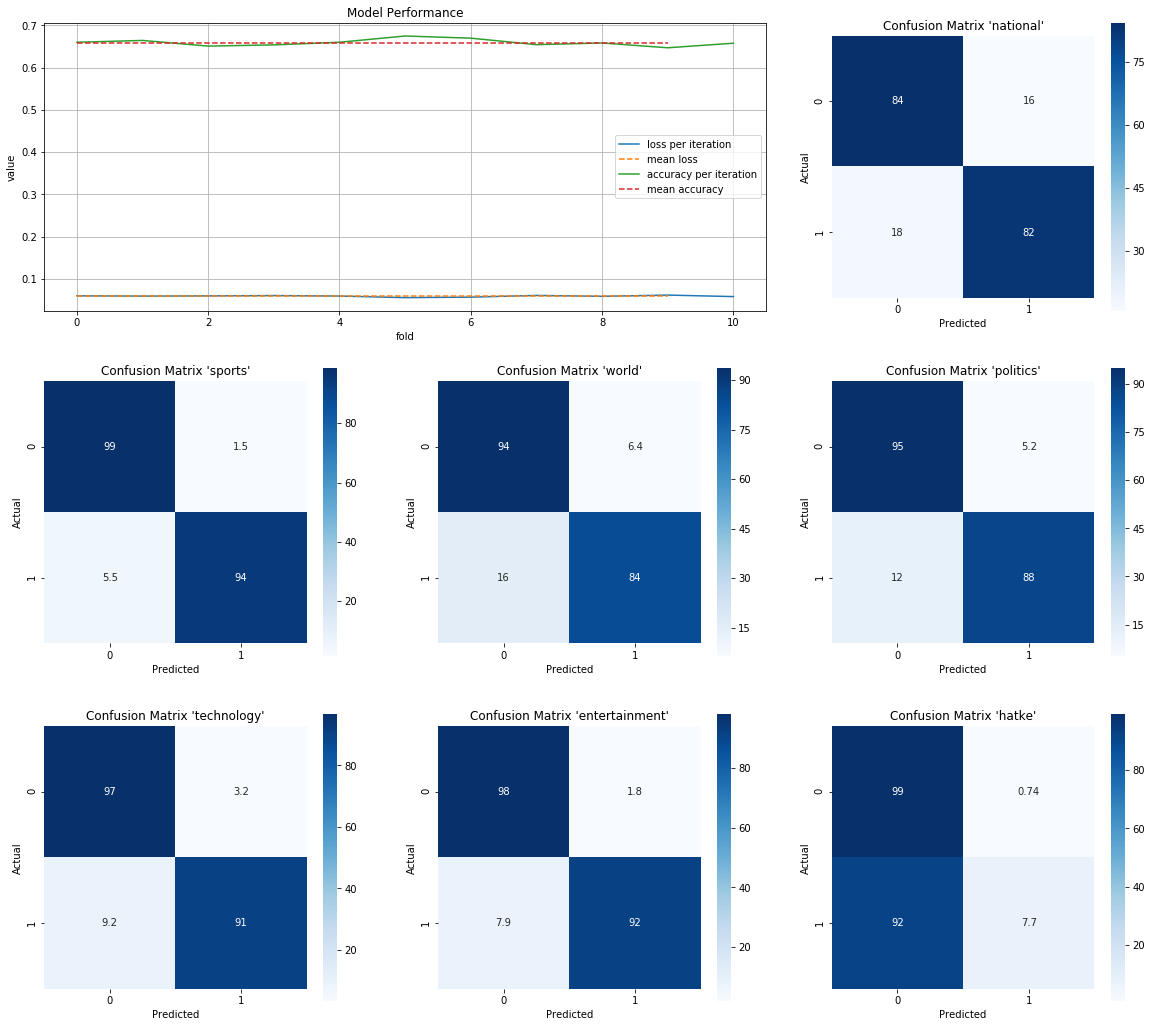

In [23]:
cleaner = TextCleaner()
vectorizer = TfidfVectorizer()
featurer = NBFeaturer()
model = LogisticRegression(class_weight='balanced', random_state=101, solver='lbfgs', max_iter=1_000, warm_start=True)
p = Pipeline([
    ('cleaner', cleaner),
    ('vectorizer', vectorizer),
    ('nb-featurer', featurer),
    ('model', model)
])

p_performance, p_cm, p_model = train_model_one_vs_rest(p, data['news'].values, Y, labels)
print('Mean Hamming Loss', round(np.mean(p_performance['loss']), 4), '+-', round(np.std(p_performance['loss']), 4))

In [24]:
pickle.dump(p_model, open('NewsClassificationPipeline.pkl', 'wb'))